<a href="https://www.kaggle.com/code/akifkara217/notebook4ecf0e62ff?scriptVersionId=202267375" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Gerekli Kütüphaneler

İlk olarak gerekli kütüphaneleri import edelim:

In [1]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



# Veri Yolu ve Dosyaların Hazırlanması

In [2]:
# Veri seti için yol
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset'

# Dosyaları ve etiketleri toplama
label = []
path = []

for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':  # Eğer dosya png ise
            if dir_name.split('/')[-1] != 'GT':  # Klasör GT içermiyorsa
                label.append(os.path.split(dir_name)[-1])  # Klasör ismini etiket olarak al
                path.append(os.path.join(dir_name, filename))  # Dosya yolunu kaydet

# Pandas DataFrame oluşturma
data = pd.DataFrame(columns=['path', 'label'])
data['path'] = path
data['label'] = label

# Data'yı inceleyelim
print(data.head())


                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel


# 3. Eğitim, Doğrulama ve Test Verilerini Ayırma

Şimdi bu verileri bir TensorFlow modeli için uygun hale getirelim. İlk olarak veriyi eğitim ve test olarak ikiye böleceğiz ve ardından ImageDataGenerator ile veri augmentasyonu yapacağız.

In [3]:
# Eğitim ve test verilerini ayırma
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['label'])

# Doğrulama verileri için eğitim verilerinin bir kısmını ayırma
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['label'])


# 4. Veri Yükleme ve Augmentasyon (Veri Zenginleştirme)

Şimdi basit bir yapay sinir ağı modeli tanımlayacağız.

In [4]:
# Batch size belirleme
batch_size = 16
image_size = (128, 128)

# tf.data.Dataset ile veri seti oluşturma
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = image / 255.0
    return image, label

# Etiketleri one-hot encoding'e dönüştürme
def one_hot_label(label, class_names):
    one_hot = tf.equal(class_names, label)
    return tf.cast(one_hot, tf.float32)

# Dataset oluşturma
def create_dataset(data, class_names):
    image_paths = data['path'].values
    labels = data['label'].values
    labels = [one_hot_label(label, class_names) for label in labels]
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: preprocess_image(x, y))
    dataset = dataset.shuffle(buffer_size=len(data))
    dataset = dataset.batch(batch_size)
    return dataset

# Sınıf isimleri
class_names = sorted(train_data['label'].unique())

# Dataset'leri oluşturma ve repeat() kullanma
train_dataset = create_dataset(train_data, class_names).repeat()
val_dataset = create_dataset(val_data, class_names).repeat()
test_dataset = create_dataset(test_data, class_names)


# 5. Modeli Oluşturma

Modelin eğitim sırasında başarı ve kayıp grafiğini çizelim:

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 6. Modeli Eğitme

Test setiyle modelin başarısını değerlendirebiliriz:

In [6]:
# steps_per_epoch ve validation_steps hesaplama
steps_per_epoch = len(train_data) // batch_size
validation_steps = len(val_data) // batch_size

print("Train steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

# Modeli eğitme
try:
    history = model.fit(
        train_dataset,  # train_generator yerine
        steps_per_epoch=steps_per_epoch,
        validation_data=val_dataset,  # val_generator yerine
        validation_steps=validation_steps,
        epochs=10
    )
except Exception as e:
    print("Hata:", e)



Train steps per epoch: 720
Validation steps: 180
Epoch 1/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 326s 395ms/step - accuracy: 0.3379 - loss: 1.8954 - val_accuracy: 0.6611 - val_loss: 0.9308
Epoch 2/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 276s 376ms/step - accuracy: 0.6902 - loss: 0.8524 - val_accuracy: 0.7767 - val_loss: 0.5784
Epoch 3/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 286s 374ms/step - accuracy: 0.8084 - loss: 0.5204 - val_accuracy: 0.8479 - val_loss: 0.4182
Epoch 4/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 288s 378ms/step - accuracy: 0.8832 - loss: 0.3145 - val_accuracy: 0.8479 - val_loss: 0.4490
Epoch 5/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 292s 383ms/step - accuracy: 0.9219 - loss: 0.2178 - val_accuracy: 0.8674 - val_loss: 0.4305
Epoch 6/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 295s 391ms/step - accuracy: 0.9475 - loss: 0.1551 - val_accuracy: 0.8799 - val_loss: 0.4524
Epoch 7/10
720/720 ━━━━━━━━━━━━━━━━━━━━ 296s 398ms/step - accuracy: 0.9586 - loss: 0.1159 - val_accuracy: 0.8819 - val_loss: 0.4562
Epoch 8/10
720/720 ━━━━━━━━

# 7. Performans Analizi ve Görseller


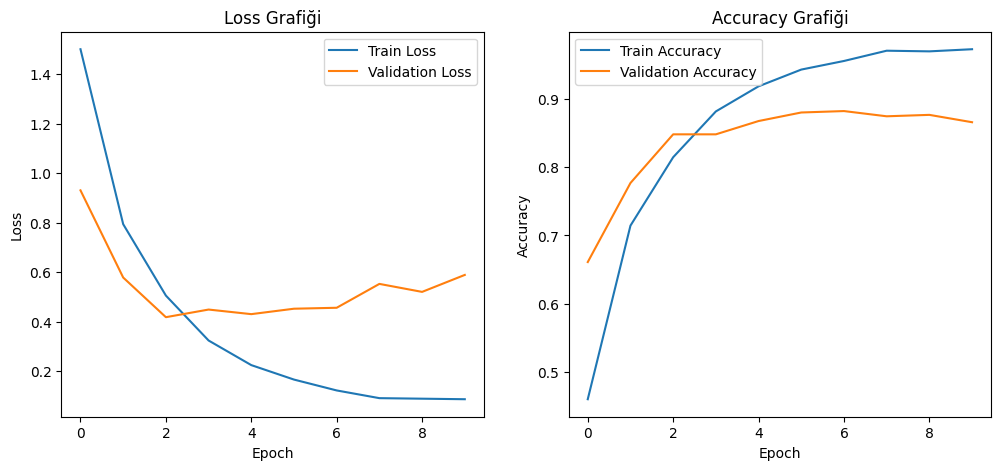

In [7]:
# Loss ve Accuracy grafikleri

plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# 8. Test Seti Üzerindeki Başarı

In [8]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - accuracy: 0.8578 - loss: 0.6271
Test Accuracy: 0.8564


# 9. Ek Görseller

İlk 10 Gözlemi Görüntüleme

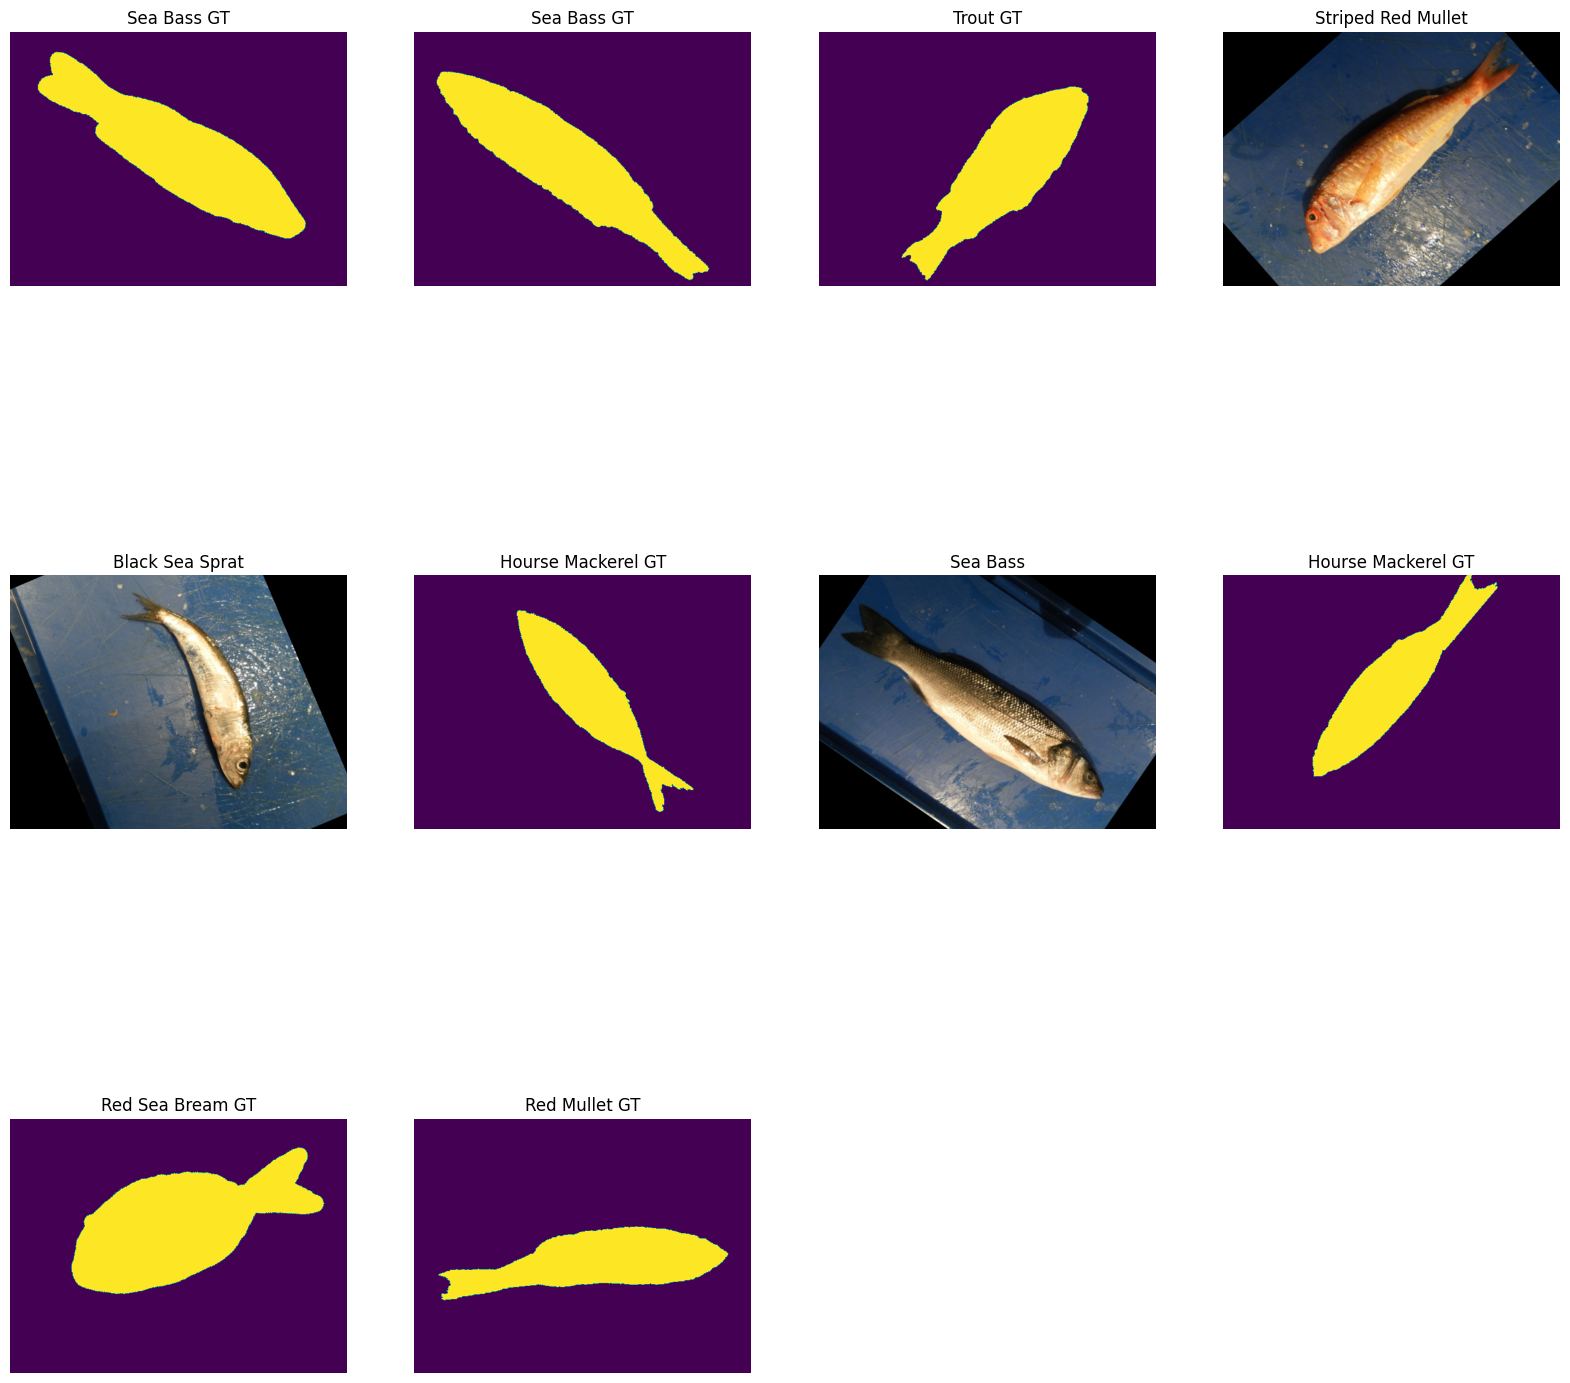

In [9]:
import matplotlib.pyplot as plt

cn = 0
plt.figure(figsize=(20, 20))

# İlk 10 görüntüyü ve etiketlerini almak için döngü
for i in range(10):
    img_path = train_data.iloc[i]['path']  # Görüntü yolu
    img_label = train_data.iloc[i]['label']  # Görüntü etiketi
    
    # Görüntüyü göster
    plt.subplot(3, 4, cn + 1)  # 3 satır ve 4 sütunlu bir grid oluştur
    plt.imshow(plt.imread(img_path))
    plt.title(img_label)  # Etiketi başlık olarak ekle
    plt.axis('off')  # Eksenleri kapat
    cn += 1

plt.show()

Piksel Yoğunluğu İnceleme

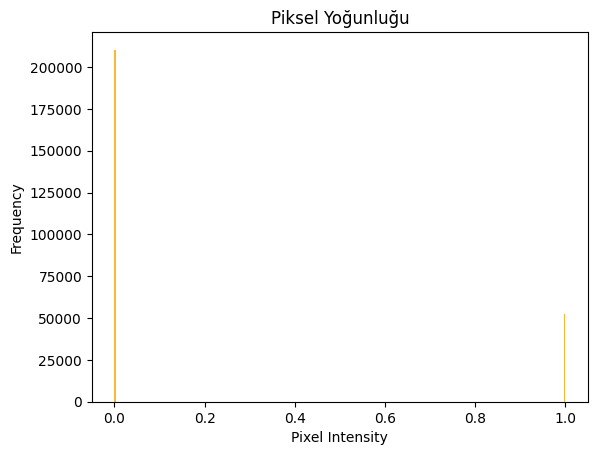

In [10]:
import numpy as np

# İlk resmin piksel yoğunluğunu inceleyelim
first_image = plt.imread(train_data.iloc[0]['path'])
plt.hist(first_image.ravel(), bins=256, color='orange', alpha=0.8)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Piksel Yoğunluğu')
plt.show()


Sınıf Dağılımı Görselleştirme

label
Hourse Mackerel          1000
Hourse Mackerel GT       1000
Red Sea Bream            1000
Gilt-Head Bream          1000
Gilt-Head Bream GT       1000
Shrimp                   1000
Shrimp GT                1000
Striped Red Mullet       1000
Striped Red Mullet GT    1000
Trout GT                 1000
Trout                    1000
Red Mullet GT            1000
Red Mullet               1000
Sea Bass GT              1000
Sea Bass                 1000
Black Sea Sprat          1000
Black Sea Sprat GT       1000
Red Sea Bream GT         1000
Name: count, dtype: int64
                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel


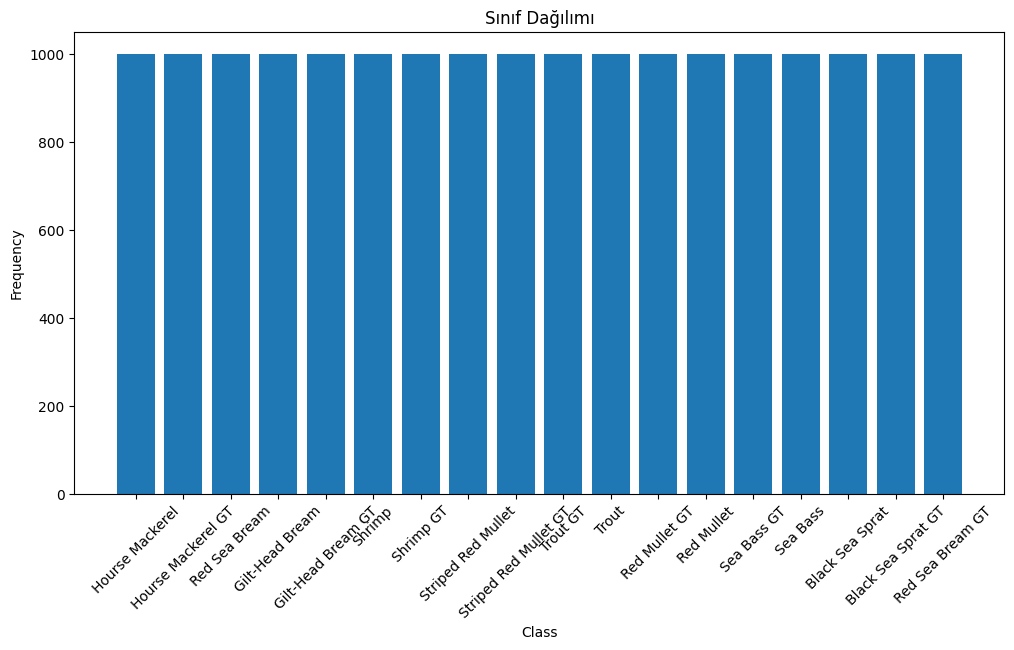

In [11]:
# Sınıf dağılımı
print(data['label'].value_counts())
print(data.head())
plt.figure(figsize=(12, 6))  # Grafik boyutunu ayarla

class_counts = data['label'].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.title('Sınıf Dağılımı')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
